In [1]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,
                      transfer_function='boltzmann_camb')

In [2]:
import numpy as np
import pylab as pl
#from astropy.cosmology import Planck18 as cosmo
from scipy import interpolate
import pickle
from scipy.integrate import quad, dblquad
import math

In [3]:
import sys
sys.path.insert(0, "/global/homes/q/qhang/desi/lya/codes/")
import lya_utils as lu

# Functions & pre-loaded data

Load pre-computed correlation functions; define functions to compute the double integrals

In [6]:
#def chi(z):
#    return cosmo.comoving_distance(z)

def r_3d_rp(rp,z1,z2):
    return ((chi(z1)-chi(z2))**2+(rp)**2)**0.5

def mu_rsd(z1,z2,r):
    return (chi(z1)-chi(z2))/r

#def ra_cosmo(z):
#    return cosmo.comoving_transverse_distance(z)

def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

def omega_m_z(z):
    return ccl.background.omega_x(cosmo, 1/(1+z), 'matter')

# logarithmic growth rate at a given redshift
def f_z(z):
    return ccl.growth_rate(cosmo,1/(1+z))

# ratio of the linear growth factor at z and at z_p
def D_z_p(z,z_p):
    return ccl.growth_factor(cosmo,1/(1+z))/ccl.growth_factor(cosmo,1/(1+z_p))

### Linear theory $\xi$

In [7]:
# now load the linear xi 0, 2, 4 here, construct interpolator as a func of r, z:
#root = "/export/donatello/qhang/nersc/qhang/desi/lya_forest_clustering_z/notebooks/"
root = "./"
fin = np.loadtxt(root + "xi_L_0.txt")
r_Mpc, xi_L_0 = fin[:,0], fin[:,1]

fin = np.loadtxt(root + "xi_L_2.txt")
xi_L_2 = fin[:,1]

fin = np.loadtxt(root + "xi_L_4.txt")
xi_L_4 = fin[:,1]

# build interpolation functions
xi_L_0 = interpolate.interp1d(r_Mpc, xi_L_0)
xi_L_2 = interpolate.interp1d(r_Mpc, xi_L_2)
xi_L_4 = interpolate.interp1d(r_Mpc, xi_L_4)

In [8]:
# linear rsd xi:
def xi_rsd_lin(R,z,mu,beta,beta2=None,z_p=3):
    """Note beta is also a function of z, we will compute it later
    """
    if beta2 == None:
        beta2 = np.copy(beta)
        
    xi_0 = (1 + 1/3.*(beta + beta2) + 1/5.*beta*beta2)*xi_L_0(R)
    xi_2 = (2/3.*(beta + beta2) + 4/7.*beta*beta2)*xi_L_2(R)
    xi_4 = 8/35.*beta*beta2*xi_L_4(R)

    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return (xi_0*P_0 + xi_2*P_2 + xi_4*P_4)*D_z_p(z,z_p)**2

In [9]:
def xi_rsd_bg_lin(R,z,mu,beta_ref,bias_ref,z_p=3):
    """
    This is the part that gets multiplied by bg(z).
    We will make it explicit in bias and beta
    """

    xi_0 = (1 + 1/3.*beta_ref)*xi_L_0(R)
    xi_2 = (2/3.)*beta_ref*xi_L_2(R)
    
    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)

    return (xi_0*P_0 + xi_2*P_2)*D_z_p(z,z_p)**2*bias_ref

def xi_rsd_fmu_lin(R,z,mu,f,beta_ref,bias_ref,z_p=3):
    """
    This is the part that's independent of bg(z).
    We will make it explicit in bias and beta
    """
    
    xi_0 = (1/3.*f + 1/5.*beta_ref*f)*xi_L_0(R)
    xi_2 = (2/3.*f + 4/7.*beta_ref*f)*xi_L_2(R)
    xi_4 = (8/35.*beta_ref*f)*xi_L_4(R)

    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return (xi_0*P_0 + xi_2*P_2 + xi_4*P_4)*D_z_p(z,z_p)**2*bias_ref

### Non-linear theory  $\xi$

Two differences: 
1. Change to non-linear power
2. Redshift depedence now interpolated (nearest neighbour) rather than explicit

In [10]:
# everything is essentially the same, except for now we use the non-linear power spectrum
Zlist=[2.+k/200 for k in range(200)]
R3d=np.logspace(-1.,2.5,num=40, endpoint=True, base=10.0, dtype=None, axis=0)

# load stuff here:
#root = "/export/donatello/qhang/nersc/qhang/desi/lya_forest_clustering_z/notebooks/"
Xi_3d=np.loadtxt(root + 'xi3d_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d=np.transpose(Xi_3d)

XI_interp=[]
for iz in range(len(Zlist)):
    XI_interp.append(interpolate.interp1d(R3d, Xi_3d[iz]))

Xi_3d_bar=np.loadtxt(root + 'xi3d_bar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_bar=np.transpose(Xi_3d_bar)

XI_bar_interp=[]
for iz in range(len(Zlist)):
    XI_bar_interp.append(interpolate.interp1d(R3d, Xi_3d_bar[iz]))
    
Xi_3d_barbar=np.loadtxt(root + 'xi3d_barbar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_barbar=np.transpose(Xi_3d_barbar)

XI_barbar_interp=[]
for iz in range(len(Zlist)):
    XI_barbar_interp.append(interpolate.interp1d(R3d, Xi_3d_barbar[iz]))

In [11]:
# now define the correlation function:
def find_z(x):
    arr=Zlist
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

In [12]:
def xi_rsd_nlin(R,z,mu,beta,beta2=None):
    """Note beta is also a function of z, we will compute it later
    """
    if beta2 == None:
        beta2 = np.copy(beta)
        
    index_z=find_z(z) # find the best z-index for xi
    
    xi_r=XI_interp[index_z]
    xi_0 = (1 + 1/3.*(beta + beta2) + 1/5.*beta*beta2)*xi_r(R)

    xi_bar_r=XI_bar_interp[index_z]
    xi_2 = (2/3.*(beta + beta2) + 4/7.*beta*beta2)*(xi_r(R) - xi_bar_r(R))

    xi_barbar = XI_barbar_interp[index_z]
    xi_4 = 8/35.*beta*beta2*(xi_r(R) + 5/2.*xi_bar_r(R) - 7/2.*xi_barbar(R))
    
    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return xi_0*P_0 + xi_2*P_2 + xi_4*P_4

In [13]:
def xi_rsd_bg_nlin(R,z,mu,beta_ref,bias_ref):
    """
    This is the part that gets multiplied by bg(z).
    We will make it explicit in bias and beta
    """
    
    index_z=find_z(z) # find the best z-index for xi
    xi_r=XI_interp[index_z]
    xi_bar_r=XI_bar_interp[index_z]

    xi_0 = (1 + 1/3.*beta_ref)*xi_r(R)
    xi_2 = (2/3.)*beta_ref*(xi_r(R) - xi_bar_r(R))
    
    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)

    return (xi_0*P_0 + xi_2*P_2)*bias_ref

def xi_rsd_fmu_nlin(R,z,mu,f,beta_ref,bias_ref):
    """
    This is the part that's independent of bg(z).
    We will make it explicit in bias and beta
    """
    
    index_z=find_z(z) # find the best z-index for xi
    xi_r=XI_interp[index_z]
    xi_bar_r=XI_bar_interp[index_z]
    xi_barbar = XI_barbar_interp[index_z]
    
    xi_0 = (1/3.*f + 1/5.*beta_ref*f)*xi_r(R)
    xi_2 = (2/3.*f + 4/7.*beta_ref*f)*(xi_r(R) - xi_bar_r(R))
    xi_4 = (8/35.*beta_ref*f)*(xi_r(R) + 5/2.*xi_bar_r(R) - 7/2.*xi_barbar(R))

    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return (xi_0*P_0 + xi_2*P_2 + xi_4*P_4)*bias_ref

### Assuming known $b_g(z)$ case

In [14]:
# this need to compute for each theta and each z centre
def wsp_full_rsd_intz1(zgrid, nz_law_ref, zlim, theta_arcmin, 
                           beta_law_ref, beta_law_unk, bias_law_ref, bias_law_unk, linear=True):
    
    """
    This function returns the xi_RSD integrated over the reference redshift distribution, 
    at a fixed anglar scale, and at a fixed redshift zgrid for the unknown sample.
    
    Parameters:
    - zgrid: fixed redshift for the unknown sample
    - nz_law_ref: reference redshift distribution function of the reference sample
    - zlim: integration limit for the reference sample, typically bin edges
    - theta_arcmin: angular scale of the pair separation in arcmin
    - beta_law_ref: beta(z) function of the refrence sample
    - beta_law_unk: beta(z, bias) function of the unknown sample, takes also the bias function
    - bias_law_ref: bias(z) function of the refrence sample
    - bias_law_unk: bias(z) function of the unknon sample
    - linear: Boolean, True = linear power spectrum, False = non linear power spectrum
    """
    
    zmin=zlim[0]
    zmax=zlim[1]
    
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    
    if linear == True:
        xi_func = xi_rsd_lin
        rlim=[0.01,1e4]
    elif linear == False:
        xi_func = xi_rsd_nlin
        rlim=[0.11,300]
    
    def integrate_z2(z2):
        zmean_pair = (zgrid + z2)/2.
        
        rp=theta_rad*ra_cosmo(zmean_pair) #from Mpc to rad, to deg
        r=r_3d_rp(rp,zgrid,z2) # what is the r3d given our redshifts
        mu = mu_rsd(zgrid,z2,r)

        if r<rlim[0]:# not too small...
            return 0
        if r>rlim[1]:# not too large...
            return 0
        
        beta1 = beta_law_unk(zgrid, bias_law_unk)
        beta2 = beta_law_ref(z2)
        nz_ref = nz_law_ref(z2)
        xilin = xi_func(r,zmean_pair,mu,beta1,beta2=beta2)*nz_ref
        return xilin*bias_law_unk(zgrid)*bias_law_ref(z2)
        
    return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


# this combines the theta for each z centre
def w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True):
    """
    w_theta_z: 1D or 2D array of w_theta. 1D = fixed z; 2D allows different z values along axis=1.
    theta_egdes: bin edges to evaluate theta (typically lognormal bins)
    theta_weight_func: computes the weights of each theta
    theta_weight_norm: boolean to determine whether normalize the weight function, default is true.
    """
    
    Ntheta=len(theta_edges)-1
    theta_bincen = (theta_edges[1:] + theta_edges[:-1])/2.
    dtheta=np.array([theta_edges[i+1]-theta_edges[i] for i in range(Ntheta)])

    weights = theta_weight_func(theta_bincen)
    
    if theta_weight_norm == True:
        norm = sum(weights*dtheta)
        weights = weights/norm
        
    if len(w_theta_z.shape) == 1:
        w_comb = sum(w_theta_z*weights*dtheta)
        
    else:
        # make sure w_theta_z has theta variation along axis = 0!
        w_comb = np.sum(w_theta_z*weights[:,None]*dtheta[:,None],axis=0)
    
    return w_comb


# this does the integral for the unknown n(z), and is what we will call in MCMC
def wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim):
    """
    w_z_func: the function that computes the wsp at various z of the unknown sample
    nz_law_unk: unknown redshift distribution function
    zlim: integration limit of the function
    """
    
    zmin = zlim[0]
    zmax = zlim[1]
    
    def integrate_z2(z):
        return nz_law_unk(z)*w_z_func(z)
    
    return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

### Assuming unknown $b_g(z)$ test case

In [15]:
# this need to compute for each theta and each z centre
def wsp_rsd_bg_intz1(zgrid, nz_law_ref, zlim, theta_arcmin, 
                           beta_law_ref, bias_law_ref, linear=True):
    
    """
    This function returns the xi_RSD integrated over the reference redshift distribution, 
    at a fixed anglar scale, and at a fixed redshift zgrid for the unknown sample,
    for the xi_rsd_bg_lin function.
    
    Parameters:
    - zgrid: fixed redshift for the unknown sample
    - nz_law_ref: reference redshift distribution function of the reference sample
    - zlim: integration limit for the reference sample, typically bin edges
    - theta_arcmin: angular scale of the pair separation in arcmin
    - beta_law_ref: beta(z) function of the refrence sample
    - bias_law_ref: bias(z) function of the refrence sample
    - linear: Boolean, True = linear power spectrum, False = non linear power spectrum
    """
    
    zmin=zlim[0]
    zmax=zlim[1]
    
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    
    if linear == True:
        xi_func = xi_rsd_bg_lin
        rlim=[0.01,1e4]
    elif linear == False:
        xi_func = xi_rsd_bg_nlin
        rlim=[0.11,300]
    
    def integrate_z2(z2):
        zmean_pair = (zgrid + z2)/2.
        
        rp=theta_rad*ra_cosmo(zmean_pair) #from Mpc to rad, to deg
        r=r_3d_rp(rp,zgrid,z2) # what is the r3d given our redshifts
        mu = mu_rsd(zgrid,z2,r)

        if r<rlim[0]:# not too small...
            return 0
        if r>rlim[1]:# not too large...
            return 0
        
        beta_ref = beta_law_ref(z2)
        bias_ref = bias_law_ref(z2)
        nz_ref = nz_law_ref(z2)
        xilin = xi_func(r,zmean_pair,mu,beta_ref,bias_ref)*nz_ref
        return xilin
        
    return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


def wsp_rsd_fmu_intz1(zgrid, nz_law_ref, zlim, theta_arcmin, 
                           beta_law_ref, bias_law_ref, linear=True):
    
    """
    This function returns the xi_RSD integrated over the reference redshift distribution, 
    at a fixed anglar scale, and at a fixed redshift zgrid for the unknown sample,
    for the xi_rsd_bg_lin function.
    
    Parameters:
    - zgrid: fixed redshift for the unknown sample
    - nz_law_ref: reference redshift distribution function of the reference sample
    - zlim: integration limit for the reference sample, typically bin edges
    - theta_arcmin: angular scale of the pair separation in arcmin
    - beta_law_ref: beta(z) function of the refrence sample
    - bias_law_ref: bias(z) function of the refrence sample
    - linear: Boolean, True = linear power spectrum, False = non linear power spectrum
    """
    
    zmin=zlim[0]
    zmax=zlim[1]
    
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    
    if linear == True:
        xi_func = xi_rsd_fmu_lin
        rlim=[0.01,1e4]
    elif linear == False:
        xi_func = xi_rsd_fmu_nlin
        rlim=[0.11,300]
    
    def integrate_z2(z2):
        zmean_pair = (zgrid + z2)/2.
        
        rp=theta_rad*ra_cosmo(zmean_pair) #from Mpc to rad, to deg
        r=r_3d_rp(rp,zgrid,z2) # what is the r3d given our redshifts
        mu = mu_rsd(zgrid,z2,r)

        if r<rlim[0]:# not too small...
            return 0
        if r>rlim[1]:# not too large...
            return 0
        
        beta_ref = beta_law_ref(z2)
        bias_ref = bias_law_ref(z2)
        nz_ref = nz_law_ref(z2)
        f = ccl.growth_rate(cosmo,1/(1+z2)) # let's call ccl directly
        xilin = xi_func(r,zmean_pair,mu,f,beta_ref,bias_ref)*nz_ref
        return xilin
        
    return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


# this does the integral for the unknown n(z) AND bg(z), and is what we will call in MCMC
def wsp_full_bg_rsd_intez2(w_z_func_bg, w_z_func_fmu, nz_law_unk, bias_law_unk, zlim):
    """
    w_z_func: the function that computes the wsp at various z of the unknown sample
    nz_law_unk: unknown redshift distribution function
    zlim: integration limit of the function
    """
    
    zmin = zlim[0]
    zmax = zlim[1]
    
    def integrate_z2(z):
        return nz_law_unk(z)*bias_law_unk(z)*w_z_func_bg(z) + nz_law_unk(z)*w_z_func_fmu(z)
    
    return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

## Load all the bias and beta laws below:

In [18]:
# load all the bias laws etc.
#root = "/export/donatello/qhang/nersc/qhang/desi/lya_forest_clustering_z/"
root = "./"
data=np.loadtxt(root + "../bias_dc2.txt")
Z_bias,bias_model=data[:,0],data[:,1]
bias_law_gal=interpolate.interp1d(Z_bias,bias_model,bounds_error=False,fill_value="extrapolate")

# Lya bias model:
def bias_law_lya(z):
    alpha = 2.9
    bias_zref = -0.1352
    zref = 2.33
    factor = 0.906 # from lya auto-correlation fits
    return bias_zref * ((1 + z)/(1 + zref))**alpha * factor

"""
# Lya beta model (need to fit quadratic)
fin = np.loadtxt("beta_lya_dr16.txt")
x,y = fin[:,0], fin[:,1]
p = np.polyfit(x,y,2)
beta_law_lya = np.poly1d(p)
"""

def beta_law_gal(z, bias_law):
    return omega_m_z(z)**0.55/bias_law(z)

# wss, fixed beta
def beta_law_lya_fixed(z):
    return 1.53

## Some tests to see the integrand

In [20]:
deltaz = 0.05 # reference redshift width
 # integral limit
theta_arcmin = 10 # angular bins
bias_law_ref = bias_law_lya
beta_law_ref = beta_law_lya_fixed
bias_law_unk = bias_law_gal
beta_law_unk = beta_law_gal

# do this on a z grid:
meanz = np.array([2.1,2.5,2.8]) # reference mean redshift
zgrid = np.linspace(1.8, 3.0, 100)

In [ ]:
# we can get the range by 
wsp_int1 = np.zeros((len(zgrid), len(meanz)))

for jj, z_ref in enumerate(meanz):
    print(z_ref)
    
    # for now define it as a top hat, in reality it should be give by n_F(z), close to a top hat.
    def nz_law_ref(z):
        if (z>(z_ref-deltaz/2.))&(z<(z_ref+deltaz/2.)):
            return 1/deltaz
        else:
            return 0
    zlim = [z_ref-deltaz/2., z_ref+deltaz/2.]
    
    for ii, z_unk in enumerate(zgrid):
        
        if (ii+1)%20 == 0:
            print(f"Working in {ii+1}")
        
        wsp_int1[ii, jj] = wsp_full_rsd_lin_intz1(z_unk, nz_law_ref, zlim, theta_arcmin, 
                               beta_law_ref, beta_law_unk, bias_law_ref, bias_law_unk)

2.1
Working in 20
Working in 40
Working in 60
Working in 80
Working in 100
2.5
Working in 20
Working in 40
Working in 60
Working in 80
Working in 100
2.8
Working in 20
Working in 40
Working in 60
Working in 80
Working in 100


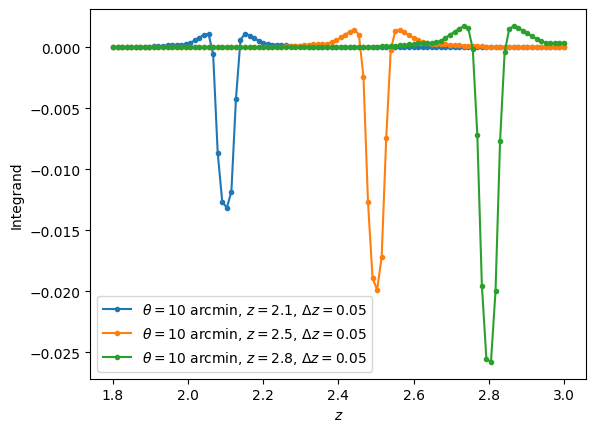

In [107]:
pl.xlabel("$z$")
pl.ylabel("Integrand")
for jj, z_ref in enumerate(meanz):
    pl.plot(zgrid, wsp_int1[:,jj], '.-',
            label=f"$\\theta=10$ arcmin, $z={z_ref}$, $\\Delta z=0.05$")
pl.legend()

In [110]:
# now also compute the dependence on theta:
zmean = 2.5
deltaz = 0.05 # reference redshift width
# for now define it as a top hat, in reality it should be give by n_F(z), close to a top hat.
def nz_law_ref(z):
    if (z>(zmean-deltaz/2.))&(z<(zmean+deltaz/2.)):
        return 1/deltaz
    else:
        return 0
zlim = [zmean-deltaz/2., zmean+deltaz/2.]
bias_law_ref = bias_law_lya
beta_law_ref = beta_law_lya_fixed
bias_law_unk = bias_law_gal
beta_law_unk = beta_law_gal

# do this on a z grid:
theta_arcmin = np.array([10,20,40]) # angular bins
zgrid = np.linspace(1.8, 3.0, 100)
# we can get the range by 
wsp_int1 = np.zeros((len(zgrid), len(theta_arcmin)))

for jj, theta in enumerate(theta_arcmin):
    print(theta)

    for ii, z_unk in enumerate(zgrid):
        
        if (ii+1)%20 == 0:
            print(f"Working in {ii+1}")
        
        wsp_int1[ii, jj] = wsp_full_rsd_intz1(z_unk, nz_law_ref, zlim, theta, 
                               beta_law_ref, beta_law_unk, bias_law_ref, bias_law_unk, linear=True)

10
Working in 20
Working in 40
Working in 60
Working in 80
Working in 100
20
Working in 20
Working in 40
Working in 60
Working in 80
Working in 100
40
Working in 20
Working in 40
Working in 60
Working in 80
Working in 100


In [119]:
# let's test code to combine the angular scales:
w_theta_z = wsp_int1.T
theta_edges = np.array([5,15,25,55])

def theta_weight_func(theta):
    return np.ones(len(theta))

wsp_int1_thetacomb = w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True)

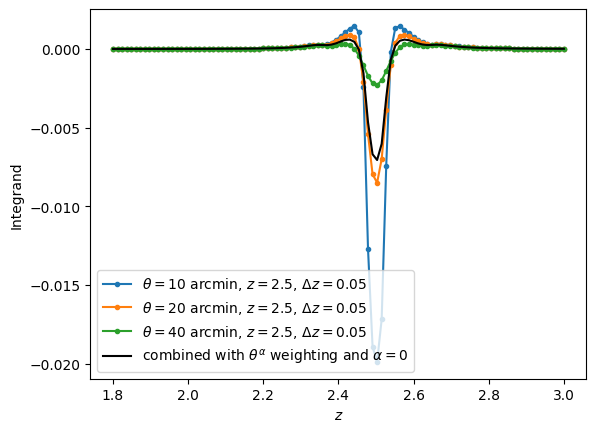

In [121]:
pl.xlabel("$z$")
pl.ylabel("Integrand")
for jj, theta in enumerate(theta_arcmin):
    pl.plot(zgrid, wsp_int1[:,jj], '.-',
            label=f"$\\theta={theta}$ arcmin, $z=2.5$, $\\Delta z=0.05$")
    
pl.plot(zgrid, wsp_int1_thetacomb, label="combined with $\\theta^{\\alpha}$ weighting and $\\alpha=0$",color='k')
pl.legend()

# Pre-compute quantities and save them

## Linear theory 

### known $b_g(z)$

In [21]:
deltaz = 0.05 # reference redshift width

bias_law_ref = bias_law_lya
beta_law_ref = beta_law_lya_fixed
bias_law_unk = bias_law_gal
beta_law_unk = beta_law_gal

# do this on a z grid:
zbin_edges = np.linspace(2,3,21) # 20 bin case
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2. # reference mean redshift
zgrid = np.linspace(1.8, 3.0, 100) # for the unknown sample
theta_edges= np.logspace(np.log10(10),np.log10(30),11)
theta_arcmin = (theta_edges[1:] + theta_edges[:-1])/2. # angular bins

# we can get the range by 
wsp_int1 = np.zeros((len(zgrid), len(meanz), len(theta_arcmin)))

for jj, z_ref in enumerate(meanz):
    
    print(z_ref)
    
    # for now define it as a top hat, in reality it should be give by n_F(z), close to a top hat.
    def nz_law_ref(z):
        if (z>(z_ref-deltaz/2.))&(z<(z_ref+deltaz/2.)):
            return 1/deltaz
        else:
            return 0
    zlim = [z_ref-deltaz/2., z_ref+deltaz/2.]
    
    for kk, theta in enumerate(theta_arcmin):
    
        for ii, z_unk in enumerate(zgrid):
            
            wsp_int1[ii, jj, kk] = wsp_full_rsd_intz1(z_unk, nz_law_ref, zlim, theta, 
                                   beta_law_ref, beta_law_unk, bias_law_ref, bias_law_unk, linear=True)

2.025
2.075
2.125
2.175
2.225
2.275
2.325
2.375
2.425
2.475
2.525
2.575
2.625
2.675
2.725
2.775
2.825
2.875
2.925
2.975


In [22]:
# save wsp_int1
out = {
    "wsp_int1": wsp_int1,
    "zgrid": zgrid,
    "zbin": meanz,
    "thetabin": theta_arcmin,
}
lu.dump_save(out, "wsp_lin_int1_theta_10_30_arcmin_20zbin.pkl")

written impute ditionary: wsp_lin_int1_theta_10_30_arcmin_20zbin.pkl


0

In [23]:
# let's now also combine the theta values and save the combined versions:

def theta_weight_func(theta):
    return np.ones(len(theta))

wsp_int1_thetacomb = np.zeros((len(meanz), len(zgrid)))

for jj, z_ref in enumerate(meanz):
    w_theta_z = wsp_int1[:,jj,:].T
    wsp_int1_thetacomb[jj,:] = w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True)

In [24]:
# save wsp_int1_thetacomb
out = {
    "wsp_int1": wsp_int1_thetacomb,
    "zgrid": zgrid,
    "zbin": meanz,
    "alpha": 0,
}
lu.dump_save(out, "wsp_lin_int1_theta_comb_20zbin.pkl")

written impute ditionary: wsp_lin_int1_theta_comb_20zbin.pkl


0

### unknown $b_g(z)$

In [25]:
deltaz = 0.05 # reference redshift width

bias_law_ref = bias_law_lya
beta_law_ref = beta_law_lya_fixed

# do this on a z grid:
zbin_edges = np.linspace(2,3,21) # 20 bin case
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2. # reference mean redshift
zgrid = np.linspace(1.8, 3.0, 100) # for the unknown sample
theta_edges= np.logspace(np.log10(10),np.log10(30),11)
theta_arcmin = (theta_edges[1:] + theta_edges[:-1])/2. # angular bins

# we can get the range by 
wsp_bg_int1 = np.zeros((len(zgrid), len(meanz), len(theta_arcmin)))
wsp_fmu_int1 = np.zeros((len(zgrid), len(meanz), len(theta_arcmin)))

for jj, z_ref in enumerate(meanz):
    
    print(z_ref)
    
    # for now define it as a top hat, in reality it should be give by n_F(z), close to a top hat.
    def nz_law_ref(z):
        if (z>(z_ref-deltaz/2.))&(z<(z_ref+deltaz/2.)):
            return 1/deltaz
        else:
            return 0
    zlim = [z_ref-deltaz/2., z_ref+deltaz/2.]
    
    for kk, theta in enumerate(theta_arcmin):
    
        for ii, z_unk in enumerate(zgrid):
            
            wsp_bg_int1[ii, jj, kk] = wsp_rsd_bg_intz1(z_unk, nz_law_ref, zlim, theta, 
                                   beta_law_ref, bias_law_ref, linear=True)
            
            wsp_fmu_int1[ii, jj, kk] = wsp_rsd_fmu_intz1(z_unk, nz_law_ref, zlim, theta, 
                                   beta_law_ref, bias_law_ref, linear=True)

2.025
2.075
2.125
2.175
2.225
2.275
2.325
2.375
2.425
2.475
2.525
2.575
2.625
2.675
2.725
2.775
2.825
2.875
2.925
2.975


In [26]:
# save
out = {
    "wsp_bg_int1": wsp_bg_int1,
    "wsp_fmu_int1": wsp_fmu_int1,
    "zgrid": zgrid,
    "zbin": meanz,
    "thetabin": theta_arcmin,
}
lu.dump_save(out, "wsp_lin_bg_fmu_int1_theta_10_30_arcmin_20zbin.pkl")

written impute ditionary: wsp_lin_bg_fmu_int1_theta_10_30_arcmin_20zbin.pkl


0

In [27]:
# let's now also combine the theta values and save the combined versions:

def theta_weight_func(theta):
    return np.ones(len(theta))

wsp_bg_int1_thetacomb = np.zeros((len(meanz), len(zgrid)))
wsp_fmu_int1_thetacomb = np.zeros((len(meanz), len(zgrid)))

for jj, z_ref in enumerate(meanz):
    w_theta_z = wsp_bg_int1[:,jj,:].T
    wsp_bg_int1_thetacomb[jj,:] = w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True)
    
    w_theta_z = wsp_fmu_int1[:,jj,:].T
    wsp_fmu_int1_thetacomb[jj,:] = w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True)

In [28]:
# save
out = {
    "wsp_bg_int1": wsp_bg_int1_thetacomb,
    "wsp_fmu_int1": wsp_fmu_int1_thetacomb,
    "zgrid": zgrid,
    "zbin": meanz,
}
lu.dump_save(out, "wsp_lin_bg_fmu_int1_theta_comb_20zbin.pkl")

written impute ditionary: wsp_lin_bg_fmu_int1_theta_comb_20zbin.pkl


0

## Non-linear theory 

### known $b_g(z)$

In [29]:
deltaz = 0.05 # reference redshift width

bias_law_ref = bias_law_lya
beta_law_ref = beta_law_lya_fixed
bias_law_unk = bias_law_gal
beta_law_unk = beta_law_gal

# do this on a z grid:
zbin_edges = np.linspace(2,3,21) # 20 bin case
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2. # reference mean redshift
zgrid = np.linspace(1.8, 3.0, 100) # for the unknown sample
theta_edges= np.logspace(np.log10(10),np.log10(30),11)
theta_arcmin = (theta_edges[1:] + theta_edges[:-1])/2. # angular bins

# we can get the range by 
wsp_int1 = np.zeros((len(zgrid), len(meanz), len(theta_arcmin)))

for jj, z_ref in enumerate(meanz):
    
    print(z_ref)
    
    # for now define it as a top hat, in reality it should be give by n_F(z), close to a top hat.
    def nz_law_ref(z):
        if (z>(z_ref-deltaz/2.))&(z<(z_ref+deltaz/2.)):
            return 1/deltaz
        else:
            return 0
    zlim = [z_ref-deltaz/2., z_ref+deltaz/2.]
    
    for kk, theta in enumerate(theta_arcmin):
    
        for ii, z_unk in enumerate(zgrid):
            
            wsp_int1[ii, jj, kk] = wsp_full_rsd_intz1(z_unk, nz_law_ref, zlim, theta, 
                                   beta_law_ref, beta_law_unk, bias_law_ref, bias_law_unk, linear=False)

2.025
2.075
2.125
2.175
2.225
2.275
2.325
2.375
2.425
2.475
2.525
2.575
2.625
2.675
2.725
2.775
2.825
2.875
2.925
2.975


In [30]:
# save wsp_int1
out = {
    "wsp_int1": wsp_int1,
    "zgrid": zgrid,
    "zbin": meanz,
    "thetabin": theta_arcmin,
}
lu.dump_save(out, "wsp_nlin_int1_theta_10_30_arcmin_20zbin.pkl")

written impute ditionary: wsp_nlin_int1_theta_10_30_arcmin_20zbin.pkl


0

In [31]:
# let's now also combine the theta values and save the combined versions:

def theta_weight_func(theta):
    return np.ones(len(theta))

wsp_int1_thetacomb = np.zeros((len(meanz), len(zgrid)))

for jj, z_ref in enumerate(meanz):
    w_theta_z = wsp_int1[:,jj,:].T
    wsp_int1_thetacomb[jj,:] = w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True)

In [32]:
# save wsp_int1_thetacomb
out = {
    "wsp_int1": wsp_int1_thetacomb,
    "zgrid": zgrid,
    "zbin": meanz,
    "alpha": 0,
}
lu.dump_save(out, "wsp_nlin_int1_theta_comb_20zbin.pkl")

written impute ditionary: wsp_nlin_int1_theta_comb_20zbin.pkl


0

### unknown $b_g(z)$

In [33]:
deltaz = 0.05 # reference redshift width

bias_law_ref = bias_law_lya
beta_law_ref = beta_law_lya_fixed

# do this on a z grid:
zbin_edges = np.linspace(2,3,21) # 20 bin case
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2. # reference mean redshift
zgrid = np.linspace(1.8, 3.0, 100) # for the unknown sample
theta_edges= np.logspace(np.log10(10),np.log10(30),11)
theta_arcmin = (theta_edges[1:] + theta_edges[:-1])/2. # angular bins

# we can get the range by 
wsp_bg_int1 = np.zeros((len(zgrid), len(meanz), len(theta_arcmin)))
wsp_fmu_int1 = np.zeros((len(zgrid), len(meanz), len(theta_arcmin)))

for jj, z_ref in enumerate(meanz):
    
    print(z_ref)
    
    # for now define it as a top hat, in reality it should be give by n_F(z), close to a top hat.
    def nz_law_ref(z):
        if (z>(z_ref-deltaz/2.))&(z<(z_ref+deltaz/2.)):
            return 1/deltaz
        else:
            return 0
    zlim = [z_ref-deltaz/2., z_ref+deltaz/2.]
    
    for kk, theta in enumerate(theta_arcmin):
    
        for ii, z_unk in enumerate(zgrid):
            
            wsp_bg_int1[ii, jj, kk] = wsp_rsd_bg_intz1(z_unk, nz_law_ref, zlim, theta, 
                                   beta_law_ref, bias_law_ref, linear=False)
            
            wsp_fmu_int1[ii, jj, kk] = wsp_rsd_fmu_intz1(z_unk, nz_law_ref, zlim, theta, 
                                   beta_law_ref, bias_law_ref, linear=False)

2.025
2.075
2.125
2.175
2.225
2.275
2.325
2.375
2.425
2.475
2.525
2.575
2.625
2.675
2.725
2.775
2.825
2.875
2.925
2.975


In [34]:
# save
out = {
    "wsp_bg_int1": wsp_bg_int1,
    "wsp_fmu_int1": wsp_fmu_int1,
    "zgrid": zgrid,
    "zbin": meanz,
    "thetabin": theta_arcmin,
}
lu.dump_save(out, "wsp_nlin_bg_fmu_int1_theta_10_30_arcmin_20zbin.pkl")

written impute ditionary: wsp_nlin_bg_fmu_int1_theta_10_30_arcmin_20zbin.pkl


0

In [35]:
# let's now also combine the theta values and save the combined versions:

def theta_weight_func(theta):
    return np.ones(len(theta))

wsp_bg_int1_thetacomb = np.zeros((len(meanz), len(zgrid)))
wsp_fmu_int1_thetacomb = np.zeros((len(meanz), len(zgrid)))

for jj, z_ref in enumerate(meanz):
    w_theta_z = wsp_bg_int1[:,jj,:].T
    wsp_bg_int1_thetacomb[jj,:] = w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True)
    
    w_theta_z = wsp_fmu_int1[:,jj,:].T
    wsp_fmu_int1_thetacomb[jj,:] = w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True)

In [36]:
# save
out = {
    "wsp_bg_int1": wsp_bg_int1_thetacomb,
    "wsp_fmu_int1": wsp_fmu_int1_thetacomb,
    "zgrid": zgrid,
    "zbin": meanz,
}
lu.dump_save(out, "wsp_nlin_bg_fmu_int1_theta_comb_20zbin.pkl")

written impute ditionary: wsp_nlin_bg_fmu_int1_theta_comb_20zbin.pkl


0

# Computations

Let's try to recover the known cases:

In [32]:
# also load n(z) of galaxies here:
fin = np.loadtxt("nz-gal-true-z1.8-3.0-all-boxes-40bin.txt")
# let's get interpolation function
nz_law_gal = interpolate.interp1d(fin[:,0],fin[:,1],fill_value=0,bounds_error=False)

## Linear theory with known $b_g(z)$

In [38]:
# load the pre-computed functions:
fin = lu.dump_load("wsp_lin_int1_theta_comb_20zbin.pkl")
wsp_int1_thetacomb = fin["wsp_int1"]
zgrid = fin["zgrid"]
meanz = fin["zbin"]
alpha = fin["alpha"]

In [40]:
np.savetxt("wsp_lin_int1_theta_comb_20zbin.wsp_int1.txt", wsp_int1_thetacomb)
np.savetxt("wsp_lin_int1_theta_comb_20zbin.zgrid.txt", zgrid)
np.savetxt("wsp_lin_int1_theta_comb_20zbin.zbin.txt", meanz)

In [36]:
# now we just need to evaluate the final integral:
# let's just do numerical integral, as we have fine enough sampling:
nz_law_unk = nz_law_gal
zlim = [1.8,3.0]
wsp_lin = np.zeros(len(meanz))

for jj, z_ref in enumerate(meanz):
    fw = wsp_int1_thetacomb[jj,:]
    w_z_func = interpolate.interp1d(zgrid, fw)
    wsp_lin[jj] = wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim)

/tmp/ipykernel_2570360/1864064068.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


## Linear theory with unknown $b_g(z)$

In [48]:
fin=lu.dump_load("wsp_lin_bg_fmu_int1_theta_comb_20zbin.pkl")
wsp_bg_int1_thetacomb=fin["wsp_bg_int1"]
wsp_fmu_int1_thetacomb=fin["wsp_fmu_int1"]
zgrid=fin["zgrid"]
meanz=fin["zbin"]

In [49]:
%%time

# now we just need to evaluate the final integral:
# let's just do numerical integral, as we have fine enough sampling:
nz_law_unk = nz_law_gal
zlim = [1.8,3.0]
bias_law_unk = bias_law_gal
wsp_lin2 = np.zeros(len(meanz))

for jj, z_ref in enumerate(meanz):
    w_z_func_bg = interpolate.interp1d(zgrid, wsp_bg_int1_thetacomb[jj,:])
    w_z_func_fmu = interpolate.interp1d(zgrid, wsp_fmu_int1_thetacomb[jj,:])
    
    wsp_lin2[jj] = wsp_full_bg_rsd_intez2(w_z_func_bg, w_z_func_fmu, nz_law_unk, bias_law_unk, zlim)

CPU times: user 1.85 s, sys: 20.1 ms, total: 1.87 s
Wall time: 1.85 s


## Non-linear theory with known $b_g(z)$

In [90]:
# load the pre-computed functions:
fin = lu.dump_load("wsp_nlin_int1_theta_comb_20zbin.pkl")
wsp_int1_thetacomb = fin["wsp_int1"]
zgrid = fin["zgrid"]
meanz = fin["zbin"]
alpha = fin["alpha"]

In [91]:
np.savetxt("wsp_nlin_int1_theta_comb_20zbin.wsp_int1.txt", wsp_int1_thetacomb)
np.savetxt("wsp_nlin_int1_theta_comb_20zbin.zgrid.txt", zgrid)
np.savetxt("wsp_nlin_int1_theta_comb_20zbin.zbin.txt", meanz)

In [33]:
# now we just need to evaluate the final integral:
# let's just do numerical integral, as we have fine enough sampling:
nz_law_unk = nz_law_gal
zlim = [1.8,3.0]
wsp_nlin = np.zeros(len(meanz))

for jj, z_ref in enumerate(meanz):
    fw = wsp_int1_thetacomb[jj,:]
    w_z_func = interpolate.interp1d(zgrid, fw)
    wsp_nlin[jj] = wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim)

/tmp/ipykernel_2570360/1864064068.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


## Non-linear theory with unknown $b_g(z)$

In [51]:
fin=lu.dump_load("wsp_nlin_bg_fmu_int1_theta_comb_20zbin.pkl")
wsp_bg_int1_thetacomb=fin["wsp_bg_int1"]
wsp_fmu_int1_thetacomb=fin["wsp_fmu_int1"]
zgrid=fin["zgrid"]
meanz=fin["zbin"]

In [52]:
# now we just need to evaluate the final integral:
# let's just do numerical integral, as we have fine enough sampling:
nz_law_unk = nz_law_gal
zlim = [1.8,3.0]
bias_law_unk = bias_law_gal
wsp_nlin2 = np.zeros(len(meanz))

for jj, z_ref in enumerate(meanz):
    w_z_func_bg = interpolate.interp1d(zgrid, wsp_bg_int1_thetacomb[jj,:])
    w_z_func_fmu = interpolate.interp1d(zgrid, wsp_fmu_int1_thetacomb[jj,:])
    
    wsp_nlin2[jj] = wsp_full_bg_rsd_intez2(w_z_func_bg, w_z_func_fmu, nz_law_unk, bias_law_unk, zlim)

# Show some plots

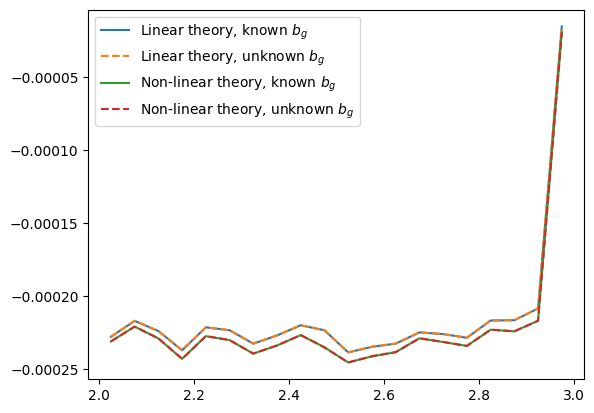

In [54]:
pl.plot(meanz, wsp_lin, label="Linear theory, known $b_g$")
pl.plot(meanz, wsp_lin2,'--', label="Linear theory, unknown $b_g$")

pl.plot(meanz, wsp_nlin, label="Non-linear theory, known $b_g$")
pl.plot(meanz, wsp_nlin2, '--', label="Non-linear theory, unknown $b_g$")
pl.legend()

In [ ]:
# we can also check the theta-split plot:



# Inference

We will set up a simple inference pipeline below:

In [37]:
import emcee

In [114]:
# set up a model for the n(z) of the unknown sample:
# for now, let's just do a shift model on the true n(z):

def log_likelihood(theta, x, y, cov):
    shift_z = theta
    def nz_law_unk(z):
        return nz_law_gal(z+shift_z)
    zlim = [1.8,3.0]
    model = np.zeros(len(x))

    for jj, z_ref in enumerate(x):
        fw = wsp_int1_thetacomb[jj,:]
        w_z_func = interpolate.interp1d(zgrid, fw)
        model[jj] = wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim)
        
    invcov = np.linalg.inv(cov)
    diff = model-y
    return -0.5*np.dot(diff, np.matmul(invcov, diff))

def log_prior(theta):
    shift_z = theta
    if (shift_z>-0.5) & (shift_z<0.5):
        return 0
    else:
        return -np.inf
    
def log_probability(theta, x, y, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, cov)

In [59]:
# load data here:
#root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/"
wsp_measure_old = np.loadtxt("w_sp-raw-thetacomb-alpha-0-min-10-max-30.txt")

In [115]:
wsp_measure_old.shape

data = wsp_measure_old[:-1,0]
cov = np.cov(wsp_measure_old[:-1,2:])*64
print(cov.shape)

(19, 19)


In [112]:
shift_z = 0.1
x = meanz[:-1]
def nz_law_unk(z):
    return nz_law_gal(z+shift_z)
zlim = [1.8,3.0]
model = np.zeros(len(x))

for jj, z_ref in enumerate(x):
    fw = wsp_int1_thetacomb[jj,:]
    w_z_func = interpolate.interp1d(zgrid, fw)
    model[jj] = wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim)

Text(0, 0.5, 'w_sp')

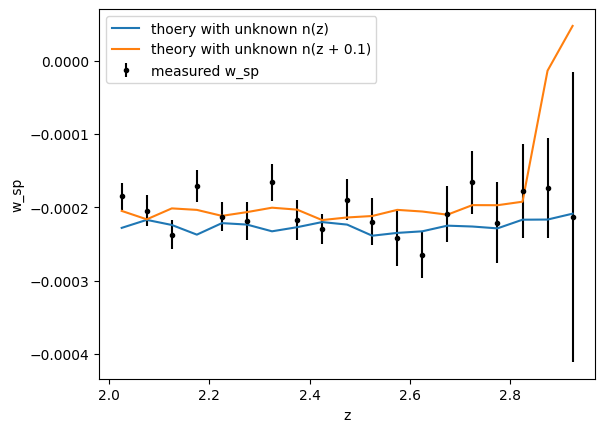

In [151]:
pl.errorbar(meanz[:-1], data, yerr=np.sqrt(np.diag(cov)),fmt='.',label="measured w_sp",color='k')
pl.plot(meanz[:-1], wsp_lin[:-1],label="thoery with unknown n(z)")
pl.plot(meanz[:-1], model,label="theory with unknown n(z + 0.1)")
pl.legend()
pl.xlabel("z")
pl.ylabel("w_sp")

In [69]:
def cov_to_corr(cov):
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    correlation = cov / outer_v
    correlation[cov == 0] = 0
    return correlation

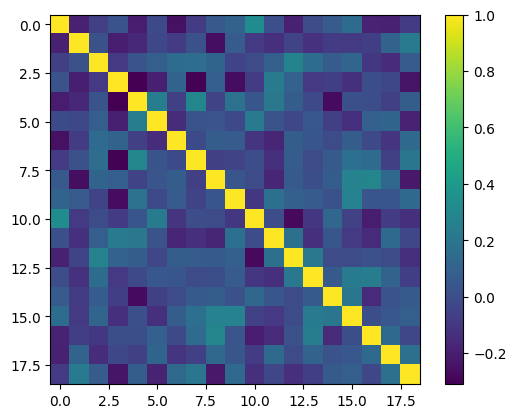

In [85]:
corr = cov_to_corr(cov)
pl.imshow(corr)
pl.colorbar()

In [134]:
from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

24 CPUs


In [136]:
nwalkers = 10
ndim=1
p0 = np.random.rand(nwalkers, ndim)-0.5
print(p0)

[[ 0.21983875]
 [-0.04620869]
 [-0.06017804]
 [-0.0999252 ]
 [ 0.06898719]
 [ 0.19537988]
 [ 0.05623382]
 [ 0.48811324]
 [-0.40949994]
 [ 0.25265875]]


In [138]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[meanz[:-1], data, cov], pool=pool)

    #state = sampler.run_mcmc(p0, 100)
    #sampler.reset()
    
    #print("Done reset.")
    sampler.run_mcmc(p0, 1000)

/tmp/ipykernel_2570360/1864064068.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
/tmp/ipykernel_2570360/1864064068.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
/tmp/ipykernel_2570360/1864064068.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
/tmp/ipykernel_2570360/1864064068.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
/tmp/ipykernel_2570360/1864064068.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsab

In [139]:
samples = sampler.get_chain(flat=True)

In [140]:
samples.shape

(10000, 1)

In [83]:
# let's load back the chains run on nersc:
filename = "/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/inference/linear_known_bg/chain.h5"

reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
print(tau)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(flat=True,discard=burnin,thin=thin)
log_prob_samples = reader.get_log_prob(flat=True,discard=burnin,thin=thin)
log_prior_samples = reader.get_blobs(flat=True,discard=burnin,thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

[27.18727079]
burn-in: 54
thin: 13
flat chain shape: (7232, 1)
flat log prob shape: (7232,)


AttributeError: 'NoneType' object has no attribute 'shape'

In [93]:
# let's load back the chains run on nersc:
filename = "/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/inference/nonlinear_known_bg/chain.h5"

reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
print(tau)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples2 = reader.get_chain(flat=True,discard=burnin,thin=thin)
log_prob_samples = reader.get_log_prob(flat=True,discard=burnin,thin=thin)
log_prior_samples = reader.get_blobs(flat=True,discard=burnin,thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples2.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

[30.70118257]
burn-in: 61
thin: 15
flat chain shape: (6240, 1)
flat log prob shape: (6240,)


AttributeError: 'NoneType' object has no attribute 'shape'

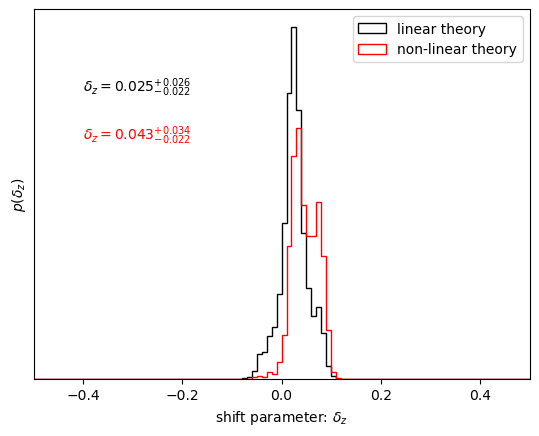

In [106]:
pl.hist(samples[:, 0], 100, range=[-0.5,0.5], color="k", histtype="step", label="linear theory")
mcmc = np.percentile(samples[:, i], [16, 50, 84])
q = np.diff(mcmc)
txt = "$ \\delta_z = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
txt = txt.format(mcmc[1], q[0], q[1])
pl.text(-0.4, 1200, txt)

pl.hist(samples2[:, 0], 100, range=[-0.5,0.5], color="r", histtype="step", label="non-linear theory")
mcmc = np.percentile(samples2[:, i], [16, 50, 84])
q = np.diff(mcmc)
txt = "$ \\delta_z = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
txt = txt.format(mcmc[1], q[0], q[1])
pl.text(-0.4, 1000, txt, color='r')

pl.xlabel(r"shift parameter: $\delta_z$")
pl.ylabel(r"$p(\delta_z)$")
pl.gca().set_yticks([]);
pl.xlim([-0.5,0.5])
pl.legend()


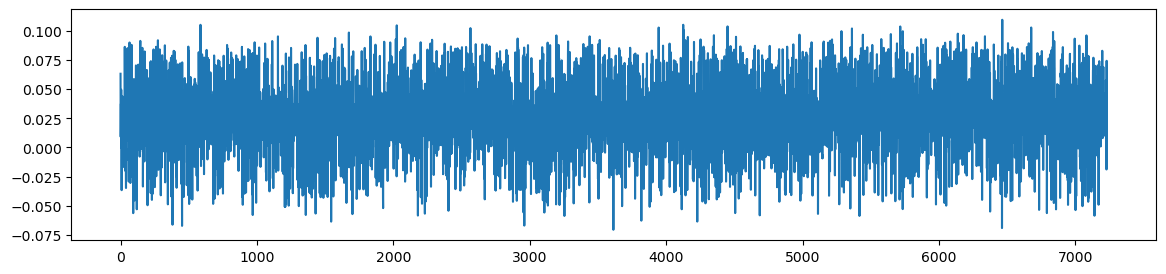

In [88]:
pl.figure(figsize=[14,3])
pl.plot(samples[:,0])

In [99]:
from IPython.display import display, Math
labels=["\delta z"]
ndim=1
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

    mcmc = np.percentile(samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2317430/3634069780.py:2: SyntaxWarning: invalid escape sequence '\d'
  labels=["\delta z"]
/tmp/ipykernel_2317430/3634069780.py:7: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
/tmp/ipykernel_2317430/3634069780.py:13: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>